# Calculate and plot spectra of PAGES2k dataset by archive types

In this notebook, we demonstrate how to perform spectral analysis on PAGES2k dataset and plot the results.

We will be using `pyleoclim` for spectral analysis, which could be installed by `pip install pyleoclim`.

`tqdm` is used to show a progress bar, which could be installed by `pip install tqdm`.

In [1]:
import numpy as np
import pandas as pd
from pyleoclim import Timeseries, Spectral
from tqdm import tqdm
import warnings
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import seaborn as sns

In [2]:
class PAGES2k(object):
    ''' A bunch of PAGES2k style settings
    '''
    archive_types = ['bivalve',
                     'borehole',
                     'coral',
                     'documents',
                     'glacier ice',
                     'hybrid',
                     'lake sediment',
                     'marine sediment',
                     'sclerosponge',
                     'speleothem',
                     'tree',
                     ]
    markers = ['p', 'p', 'o', 'v', 'd', '*', 's', 's', '8', 'D', '^']
    markers_dict = dict(zip(archive_types, markers))
    colors = [np.array([ 1.        ,  0.83984375,  0.        ]),
              np.array([ 0.73828125,  0.71484375,  0.41796875]),
              np.array([ 1.        ,  0.546875  ,  0.        ]),
              np.array([ 0.41015625,  0.41015625,  0.41015625]),
              np.array([ 0.52734375,  0.8046875 ,  0.97916667]),
              np.array([ 0.        ,  0.74609375,  1.        ]),
              np.array([ 0.25390625,  0.41015625,  0.87890625]),
              np.array([ 0.54296875,  0.26953125,  0.07421875]),
              np.array([ 1         ,           0,           0]),
              np.array([ 1.        ,  0.078125  ,  0.57421875]),
              np.array([ 0.1953125 ,  0.80078125,  0.1953125 ])]
    colors_dict = dict(zip(archive_types, colors))
    
def annualize_ts(ys, ts):                                                                                                        
    year_int = list(set(np.floor(ts)))                                                                                           
    year_int = np.sort(list(map(int, year_int)))                                                                                 
    n_year = len(year_int)                                                                                                       
    year_int_pad = list(year_int)                                                                                                
    year_int_pad.append(np.max(year_int)+1)                                                                                      
    ys_ann = np.zeros(n_year)                                                                                                    
                                                                                                                                 
    for i in range(n_year):                                                                                                      
        t_start = year_int_pad[i]                                                                                                
        t_end = year_int_pad[i+1]                                                                                                
        t_range = (ts > t_start) & (ts <= t_end)                                                                                 
        value_between = ys[t_range]                                                                                              
        if np.size(value_between) == 0:                                                                                          
            ys_ann[i] = np.nan                                                                                                   
        else:                                                                                                                    
            ys_ann[i] = np.average(value_between[~np.isnan(value_between)], axis=0)                                              
                                                                                                                                 
    ys_tmp = np.copy(ys_ann)                                                                                                     
    ys_ann = ys_ann[~np.isnan(ys_tmp)]                                                                                           
    year_int = year_int[~np.isnan(ys_tmp)]                                                                                       
                                                                                                                                 
    return ys_ann, year_int

def df2psd(df, freqs=None, value_name='paleoData_values', time_name='year', save_path=None,
           standardize=False, gaussianize=False):
    ''' Calculate the power spectral densities of a Pandas DataFrame PAGES2k dataset using WWZ method

    Args:
        df (Pandas DataFrame): a Pandas DataFrame
        freqs (array): frequency vector for spectral analysis
        save_path (str): if set, save the PSD result to the given path

    Returns:
        psds (2d array): the scaling exponents

    '''
    paleoData_values = df[value_name].values
    year = df[time_name].values

    n_series = len(year)
    n_freqs = np.size(freqs)
    psd_list = []
    freqs_list = []

    for k in tqdm(range(n_series), desc='Processing time series'):
        Xo = np.asarray(paleoData_values[k], dtype=np.float)
        to = np.asarray(year[k], dtype=np.float)
        Xo, to = Timeseries.clean_ts(Xo, to)
        if np.mean(np.diff(to)) < 1:
            Xo, to = annualize_ts(Xo, to)
        tau = np.linspace(np.min(to), np.max(to), np.min([np.size(to), 501]))
        res_wwz = Spectral.wwz_psd(Xo, to, freqs=freqs, tau=tau, c=1e-3, nproc=16, nMC=0,
                                   standardize=standardize, gaussianize=gaussianize)
        psd_list.append(res_wwz.psd)
        freqs_list.append(res_wwz.freqs)

    return psd_list, freqs_list


def df_append_psd_beta(df, value_name='paleoData_values', time_name='year',
                       psd_list=None, freqs_list=None, standardize=False, gaussianize=False,
                       period_ranges=[(1/200, 1/20), (1/8, 1/2)],
                       period_names=['beta_D', 'beta_I'],
                       save_path=None,
                      ):
    '''  Calculate the scaling exponent and add to a new column in the given DataFrame
    '''
    
    if psd_list is None or freqs_list is None:
        psd_list, freqs_list = df2psd(df, value_name=value_name, time_name=time_name,
                                      standardize=standardize, gaussianize=gaussianize)
    
    df_new = df.copy()
    df_new['psd'] = np.nan
    df_new['psd'] = df_new['psd'].astype(object)
    df_new['freqs'] = np.nan
    df_new['freqs'] = df_new['freqs'].astype(object)
    
    # append columns for psd and freqs
    for idx, row in df_new.iterrows():
        df_new.at[idx, 'psd'] = psd_list[idx]
        df_new.at[idx, 'freqs'] = freqs_list[idx]
    
    # calculate beta
    for i, period_range in enumerate(period_ranges):
        beta_list = []
        beta_err_list = []
        for j, psd in enumerate(psd_list):
            res = Spectral.beta_estimation(psd, freqs_list[j], period_range[0], period_range[1])
            beta_list.append(res.beta)
            beta_err_list.append(res.std_err)
        
        df_new[period_names[i]] = beta_list
        df_new[period_names[i]+'_err'] = beta_err_list
    
    if save_path:
        print(f'Saving pickle file at: {save_path}')
        dir_name = os.path.dirname(save_path)
        os.makedirs(dir_name, exist_ok=True)
        df_new.to_pickle(save_path)
    
    return df_new

def plot_psd_betahist(dfs, figsize=None, period_names=['beta_D', 'beta_I'],
                      ax1_ylim=None,
                      lgd_loc='upper right', lgd_anchor=(1.4, 1),
                      period_ticks=[2, 5, 10, 20, 50, 100, 200, 500]
                      ):
    ''' Plot the PSD as well as the distribution of beta_I and beta_D

    Args:
        dfs (a list of Pandas DataFrame): dfs for different types

    Returns:
        plot: a figure with the histagram of beta_I and beta_D with KDE distributions

    '''
    p = PAGES2k()

    n_dfs = len(dfs)
    if figsize is None:
        figsize = [12,  4*n_dfs]

    fig = plt.figure(figsize=figsize)


    for i, df in enumerate(dfs):
        # PSD
        sns.set(style="darkgrid", font_scale=2)
        ax1 = plt.subplot(n_dfs, 2, 2*i+1)
        for index, row in df.iterrows():
            archive_type = row['archiveType']
            ax1.loglog(1/row['freqs'], row['psd'], color=p.colors_dict[archive_type], alpha=0.3)

        ax1.set_xticks(period_ticks)
        ax1.set_ylabel('Spectral Density')
        ax1.set_xlabel('Period (years)')
        ax1.set_xticks(period_ticks)
        if ax1_ylim is not None:
            ax1.set_ylim(ax1_ylim)
        ax1.get_xaxis().set_major_formatter(ScalarFormatter())
        ax1.xaxis.set_major_formatter(FormatStrFormatter('%g'))
        ax1.set_xlim([np.min(period_ticks), np.max(period_ticks)])
        ax1.invert_xaxis()
        ax1.set_title('{}, {} records'.format(archive_type, len(df)), fontweight='bold')

        # distribution
        sns.set(style="ticks", font_scale=2)
        ax2 = plt.subplot(n_dfs, 2, 2*i+2)
        beta_I_str = period_names[1]
        beta_D_str = period_names[0]
        beta_I = df[beta_I_str].dropna().values
        beta_D = df[beta_D_str].dropna().values
        med_I = np.median(beta_I)
        med_D = np.median(beta_D)
        n_I = np.size(beta_I)
        n_D = np.size(beta_D)
        g1 = sns.kdeplot(beta_D, shade=False, color=p.colors_dict[archive_type], linestyle='-', ax=ax2,
                         label=r'$\{}$ = {:.2f} ({} records)'.format(beta_D_str, med_D, n_D))
        g1.axvline(x=med_D, ymin=0, ymax=0.1, linewidth=1, color=p.colors_dict[archive_type], linestyle='-')
        g2 = sns.kdeplot(beta_I, shade=False, color=p.colors_dict[archive_type], linestyle='--', ax=ax2,
                         label=r'$\{}$ = {:.2f} ({} records)'.format(beta_I_str,  med_I, n_I))
        g2.axvline(x=med_I, ymin=0, ymax=0.1, linewidth=1, color=p.colors_dict[archive_type], linestyle='--')
        ax2.legend(fontsize=18, bbox_to_anchor=lgd_anchor, loc=lgd_loc, ncol=1, frameon=False)
        ax2.set_xlim([-3, 5])
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)

    fig.tight_layout()

    return fig

In [3]:
# load the PAGES2k dataset
df = pd.read_pickle('./data/pages2k_dataset.pkl')

In [4]:
# Perform spectral anlaysis and append the results in new columns
df_new = df_append_psd_beta(df, save_path='./data/pages2k_psd_beta.pkl', standardize=True, gaussianize=True)

Processing time series:  90%|████████▉ | 622/692 [04:17<00:19,  3.54it/s]/home/fzhu/SynologyDrive/Dev/Github/Pyleoclim_util/pyleoclim/Spectral.py:1046: RuntimeWarning: invalid value encountered in less
  Neff_diff[Neff_diff < 0] = 0
Processing time series: 100%|██████████| 692/692 [04:45<00:00,  2.43it/s]


Saving pickle file at: ./data/pages2k_psd_beta.pkl


In [5]:
df_new = pd.read_pickle('./data/pages2k_psd_beta.pkl')

In [6]:
# let's check the dataframe with PSD and beta values appended
df_new

,paleoData_pages2kID,dataSetName,archiveType,geo_meanElev,geo_meanLat,geo_meanLon,year,yearUnits,paleoData_variableName,paleoData_units,paleoData_values,paleoData_proxy,psd,freqs,beta_D,beta_D_err,beta_I,beta_I_err
0,NAm_153,NAm-Bennington.Luckman.2001,tree,1850,52.7,-118.3,"[1563.0, 1564.0, 1565.0, 1566.0, 1567.0, 1568....",AD,trsgi,NA,"[0.883, 0.942, 1.043, 0.945, 1.141, 0.715, 0.6...",TRW,"[0.0, 6.711692944265492, 33.980266538594634, 0...","[0.0, 0.002304147465437788, 0.0046082949308755...",-0.057928,0.420472,0.241702,0.066635
1,Asi_245,Asi-SouthChina.Wang.1998,documents,2200,23,114,"[1500.0, 1510.0, 1520.0, 1530.0, 1540.0, 1550....",AD,temperature,index,"[0.157429639092533, -0.118646665464906, 0.3035...",historic,"[0.0, 63.30753069610715, 27.34276759553836, 94...","[0.0, 0.002173913043478261, 0.0043478260869565...",0.653157,0.592777,NaN,NaN
2,NAm_165,NAm-RedMountainPassSilverton.Graybill.1994,tree,3400,37.9,-107.7,"[1626.0, 1627.0, 1628.0, 1629.0, 1630.0, 1631....",AD,MXD,NA,"[1.071, 1.014, 1.014, 0.966, 1.005, 1.072, 1.0...",MXD,"[0.0, 18.911907647076283, 12.687608545954927, ...","[0.0, 0.002793296089385475, 0.0055865921787709...",0.487700,0.650261,-0.174339,0.114061
3,Asi_178,Asi-BURGPW.PAGES2k.2013,tree,2500,28.77,83.73,"[1303.0, 1304.0, 1305.0, 1306.0, 1307.0, 1308....",AD,trsgi,NA,"[0.889, 0.788, 0.836, 0.741, 0.613, 0.732, 0.7...",TRW,"[0.0, 23.52148841705719, 16.087022592721482, 4...","[0.0, 0.001440922190201729, 0.0028818443804034...",-0.653966,0.214124,0.419298,0.051763
4,Asi_174,Asi-NEPA029.Krusic.2013,tree,4000,28.18,85.43,"[1559.0, 1560.0, 1561.0, 1562.0, 1563.0, 1564....",AD,trsgi,NA,"[1.172, 1.21, 1.145, 1.307, 1.368, 1.37, 1.152...",TRW,"[0.0, 13.935085368439632, 5.760228586212013, 0...","[0.0, 0.0022935779816513763, 0.004587155963302...",-0.637432,0.484117,1.810466,0.117784
5,Eur_016,Eur-Seebergsee.Larocque-Tobler.2012,lake sediment,1830,46.15,7.5,"[2001.0, 2000.0, 1999.0, 1998.0, 1997.0, 1996....",AD,temperature,degC,"[0.87088, 0.90377, 0.94562, 0.93462, 0.91326, ...",midge,"[0.0, 100.71259350637357, 91.90609842412017, 2...","[0.0, 0.0010893246187363835, 0.002178649237472...",0.913963,0.496041,1.975527,0.047562
6,Asi_198,Asi-PAKI027.Cook.2013,tree,2670,35.35,71.93,"[1511.0, 1512.0, 1513.0, 1514.0, 1515.0, 1516....",AD,trsgi,NA,"[1.076, 1.556, 1.117, 1.522, 1.355, 1.344, 1.3...",TRW,"[0.0, 100.54421895435632, 34.16913760651721, 1...","[0.0, 0.0020161290322580645, 0.004032258064516...",0.198667,0.365673,0.563652,0.081367
7,NAm_145,NAm-BlanchardRiver.Luckman.2013,tree,931,59.9,-136.8,"[1670.0, 1671.0, 1672.0, 1673.0, 1674.0, 1675....",AD,trsgi,NA,"[1.117, 1.229, 1.221, 1.202, 0.801, 1.061, 1.0...",TRW,"[0.0, 14.21795705448285, 91.26450857420474, 15...","[0.0, 0.0029940119760479044, 0.005988023952095...",0.742484,0.359005,-0.499231,0.079493
8,Arc_070,Arc-LakeE.D'Andrea.2011,lake sediment,170,67,-50.7,"[1876.20350642055, 1865.43185219727, 1854.9566...",AD,temperature,degC,"[-0.624, -0.644, -0.625, -0.625, -0.581, -0.58...",alkenone,"[0.0, 503.5582395206585, 752.9924683484679, 11...","[0.0, 0.00021953474388399711, 0.00043906948776...",NaN,NaN,NaN,NaN
9,Arc_071,Arc-Laanila.Lindholm.2013,tree,265,68.4917,27.3333,"[800.0, 801.0, 802.0, 803.0, 804.0, 805.0, 806...",AD,MXD,NaN,"[-2.08, -0.99, -1.3, -2.03, -0.99, -1.39, -0.8...",MXD,"[0.0, 26.80922181532179, 41.40181132867903, 31...","[0.0, 0.0008291873963515755, 0.001658374792703...",0.828269,0.214300,0.099222,0.027516


/home/fzhu/SynologyDrive/Dev/miniconda3/envs/py3.6/lib/python3.6/site-packages/ipykernel_launcher.py:183: RuntimeWarning: divide by zero encountered in true_divide
/home/fzhu/SynologyDrive/Dev/miniconda3/envs/py3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/fzhu/SynologyDrive/Dev/miniconda3/envs/py3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


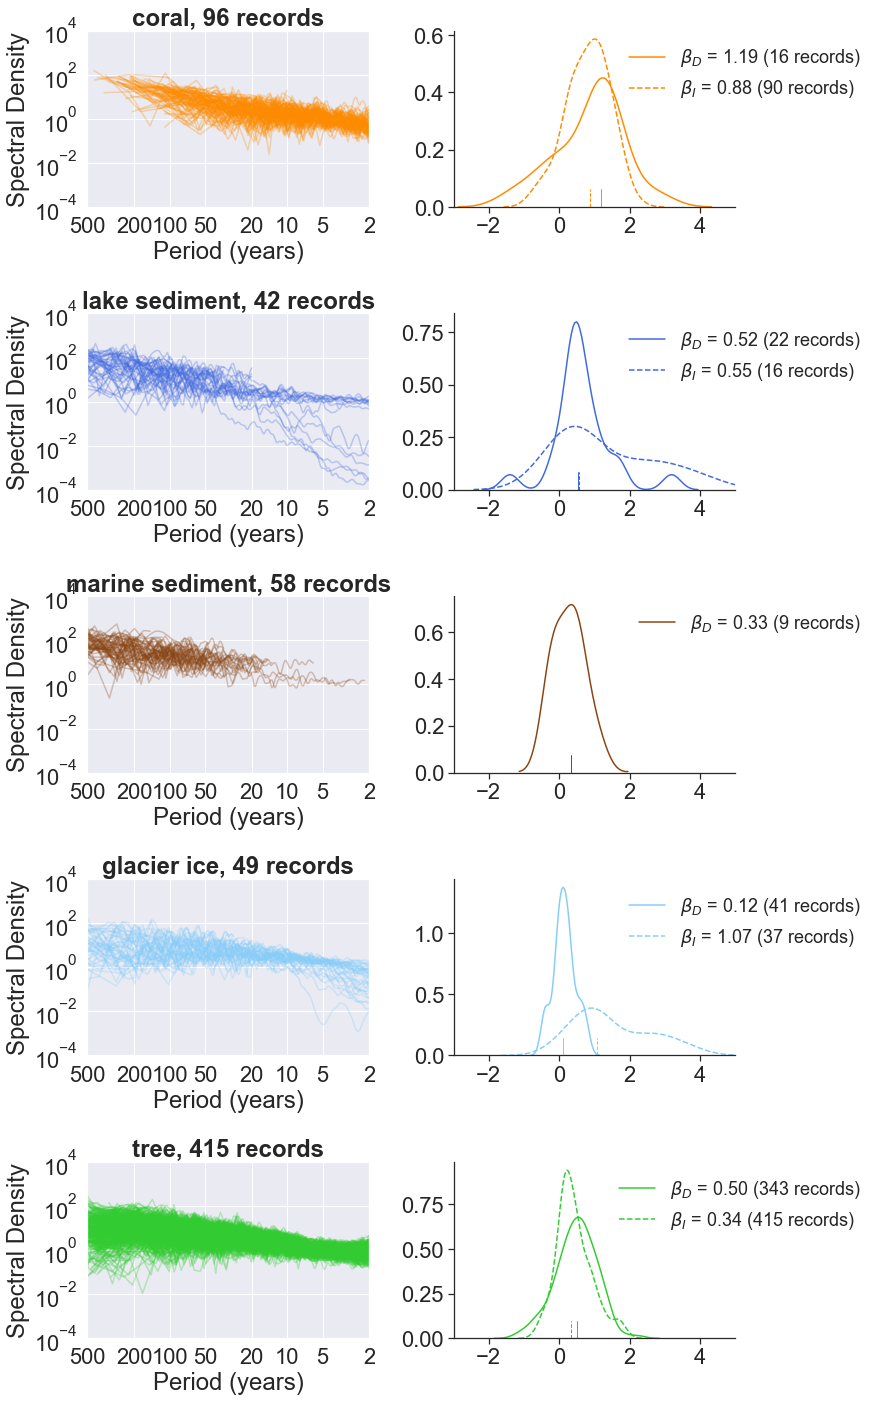

In [7]:
# drop the beta values if the standard deviation of the error of beta estimation is larger than 0.5
l_bd = 0.5    
for idx, row in df_new.iterrows():
    if row['beta_D_err'] > l_bd:
        df_new.loc[idx, 'beta_D'] = np.nan
    if row['beta_I_err'] > l_bd:
        df_new.loc[idx, 'beta_I'] = np.nan
        
# create dataframes by archive types
df_coral = df_new[df_new['archiveType']=='coral']
df_tree = df_new[df_new['archiveType']=='tree']
df_ice = df_new[df_new['archiveType']=='glacier ice']
df_marine = df_new[df_new['archiveType']=='marine sediment']
df_lake = df_new[df_new['archiveType']=='lake sediment']
df_doc = df_new[df_new['archiveType']=='documents']
        
# plot PSD and beta distribution
fig = plot_psd_betahist([df_coral, df_lake, df_marine, df_ice, df_tree],
                        lgd_anchor=(1.5, 1), figsize=[13, 20], ax1_ylim=[1e-4, 1e4])
# fig.savefig('./figs/pages2k_psd_betahist_filtered.pdf', bbox_inches='tight')
fig.savefig('./figs/pages2k_psd_betahist_filtered.png', bbox_inches='tight')